# Dead Token Dynamics: First Principles

**Purpose:** Understand exactly what happens to a dead token during one training step.

We'll use the Crucible architecture (2-layer, 2-head, 64D, 10k vocab) with the same seed and corpus as Crucible 1 & 2, so the numbers we see here are the *exact same* numbers from those experiments' first steps.

But instead of rushing through 500 steps, we execute **one step** with every intermediate value exposed:

1. Forward pass → extract **h** (hidden state)
2. Compute logits, softmax, loss
3. Compute gradients (especially for dead tokens)
4. Apply Adam optimizer
5. Update W and measure displacement

**Questions we're answering:**
- What does h look like? (magnitude, distribution, structure)
- Why do dead token gradients point antiparallel to h?
- What determines the magnitude of the kick?
- How does Adam modify the raw gradient?

---

## Setup: Same as Crucible 1 & 2

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer
from safetensors.torch import load_file
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


In [2]:
# Parameters (identical to Crucible 1 & 2)
RANDOM_SEED = 42
VOCAB_SIZE = 10000
HIDDEN_DIM = 64
NUM_LAYERS = 2
NUM_HEADS = 2
SEQ_LEN = 128
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.0
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-8

# Paths
CORPUS_PATH = '../box_4/data/flannel_model_corpus.txt'
TOKENIZER_PATH = '../box_4/data/flannel_tokenizer_chars.json'
DEAD_MASK_PATH = '../box_4/tensors/Flannel/live_dead_tokens.safetensors'

print(f"Crucible architecture: {VOCAB_SIZE} tokens, {HIDDEN_DIM}D, {NUM_LAYERS} layers, {NUM_HEADS} heads")
print(f"Training: lr={LEARNING_RATE}, AdamW (β₁={BETA1}, β₂={BETA2}, ε={EPSILON})")

Crucible architecture: 10000 tokens, 64D, 2 layers, 2 heads
Training: lr=0.001, AdamW (β₁=0.9, β₂=0.999, ε=1e-08)


In [3]:
# Set random seeds (same as Crucible)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

if device == 'cuda':
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"Random seed: {RANDOM_SEED}")

Random seed: 42


## Load Tokenizer and Dead Token Mask

The dead token mask identifies which tokens were never seen during Flannel's training.

In [4]:
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
print(f"Tokenizer vocab size: {tokenizer.get_vocab_size()}")

masks = load_file(DEAD_MASK_PATH)
dead_mask = masks['dead_mask'].bool()
dead_indices = masks['dead_indices'].long()
n_dead = dead_mask.sum().item()

print(f"Dead tokens: {n_dead}")
print(f"Live tokens: {VOCAB_SIZE - n_dead}")
print(f"\nExample dead token indices: {dead_indices[:10].tolist()}")

Tokenizer vocab size: 10000
Dead tokens: 3699
Live tokens: 6301

Example dead token indices: [0, 1, 2, 93, 95, 97, 101, 102, 109, 111]


## Dataset

Same corpus as Crucible. We'll take the first batch after shuffling with seed 42.

In [5]:
class TextDataset(Dataset):
    def __init__(self, corpus_path, tokenizer, seq_len):
        with open(corpus_path, 'r', encoding='utf-8') as f:
            text = f.read()
        encoding = tokenizer.encode(text)
        self.tokens = encoding.ids
        self.seq_len = seq_len
        self.n_sequences = len(self.tokens) // seq_len
        
    def __len__(self):
        return self.n_sequences
    
    def __getitem__(self, idx):
        start = idx * self.seq_len
        chunk = self.tokens[start:start + self.seq_len]
        return torch.tensor(chunk, dtype=torch.long)

dataset = TextDataset(CORPUS_PATH, tokenizer, SEQ_LEN)
print(f"Dataset: {len(dataset)} sequences of length {SEQ_LEN}")

# Create dataloader with same shuffle seed
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

# Get the first batch (this is what Crucible 1 & 2 used for step 1)
first_batch = next(iter(dataloader))
print(f"First batch shape: {first_batch.shape}")
print(f"First batch token range: [{first_batch.min()}, {first_batch.max()}]")

Dataset: 10713 sequences of length 128
First batch shape: torch.Size([128, 128])
First batch token range: [3, 9998]


## Model Definition

Standard 2-layer transformer with tied embeddings (W_embed = W_unembed).

In [6]:
class TinyLM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_layers, num_heads, seq_len):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.pos_embedding = nn.Embedding(seq_len, hidden_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=0.0,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln_f = nn.LayerNorm(hidden_dim)
        
        # Initialization (same as Crucible)
        nn.init.normal_(self.embedding.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.pos_embedding.weight, mean=0.0, std=0.02)
        
    def forward(self, input_ids, return_hidden=False):
        """If return_hidden=True, returns (logits, h) where h is the final hidden state."""
        batch_size, seq_len = input_ids.shape
        
        tok_emb = self.embedding(input_ids)
        pos_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        pos_emb = self.pos_embedding(pos_ids)
        
        hidden = tok_emb + pos_emb
        causal_mask = nn.Transformer.generate_square_subsequent_mask(seq_len, device=input_ids.device)
        hidden = self.transformer(hidden, mask=causal_mask, is_causal=True)
        hidden = self.ln_f(hidden)  # This is h
        
        logits = hidden @ self.embedding.weight.T
        
        if return_hidden:
            return logits, hidden
        return logits

model = TinyLM(VOCAB_SIZE, HIDDEN_DIM, NUM_LAYERS, NUM_HEADS, SEQ_LEN)
model = model.to(device).to(torch.bfloat16)

print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

Model initialized with 748,288 parameters


/Users/jefferyharrell/Projects/Azimuth_II/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [7]:
# Initialize optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(BETA1, BETA2),
    eps=EPSILON,
    weight_decay=WEIGHT_DECAY
)

print(f"Optimizer: AdamW(lr={LEARNING_RATE}, β₁={BETA1}, β₂={BETA2}, ε={EPSILON}, weight_decay={WEIGHT_DECAY})")

Optimizer: AdamW(lr=0.001, β₁=0.9, β₂=0.999, ε=1e-08, weight_decay=0.0)


## Capture Initial State (t=0)

Before any training, let's see where the dead tokens start.

In [8]:
W_initial = model.embedding.weight.detach().cpu()[dead_mask].to(torch.bfloat16)

print(f"Initial dead token embeddings: {W_initial.shape}")
print(f"\nStatistics:")
print(f"  Mean: {W_initial.float().mean():.6f}")
print(f"  Std: {W_initial.float().std():.6f}")
print(f"  L2 norms: min={torch.norm(W_initial.float(), dim=1).min():.6f}, max={torch.norm(W_initial.float(), dim=1).max():.6f}")

Initial dead token embeddings: torch.Size([3699, 64])

Statistics:
  Mean: 0.000000
  Std: 0.019973
  L2 norms: min=0.113807, max=0.210550


---

# Part 1: Forward Pass

We run the model on the first batch and extract **h**, the hidden state vector that feeds into the unembedding layer.

In [9]:
model.eval()  # No dropout, but doesn't matter (dropout=0 anyway)
input_ids = first_batch.to(device)

with torch.no_grad():
    with torch.autocast(device_type=device if device != 'mps' else 'cpu', dtype=torch.bfloat16):
        logits, h = model(input_ids, return_hidden=True)

# h is [batch_size, seq_len, hidden_dim]
print(f"Hidden state h shape: {h.shape}")
print(f"Logits shape: {logits.shape}")

Hidden state h shape: torch.Size([128, 128, 64])
Logits shape: torch.Size([128, 128, 10000])


## Inspect h

Let's look at one specific hidden state vector. We'll pick the last position of the first sequence (h[0, -1, :])—this is the vector that would predict the next token.

In [10]:
h_sample = h[0, -1, :].cpu().float()  # [64]

print(f"Sample h (from position [0, -1]):")
print(f"  Shape: {h_sample.shape}")
print(f"  Mean: {h_sample.mean():.6f}")
print(f"  Std: {h_sample.std():.6f}")
print(f"  L2 norm: {torch.norm(h_sample):.6f}")
print(f"  Min: {h_sample.min():.6f}")
print(f"  Max: {h_sample.max():.6f}")
print(f"\nFirst 10 components: {h_sample[:10].tolist()}")

Sample h (from position [0, -1]):
  Shape: torch.Size([64])
  Mean: 0.000450
  Std: 1.007977
  L2 norm: 8.000574
  Min: -2.125000
  Max: 2.359375

First 10 components: [0.390625, -1.1875, -1.3984375, -0.5390625, 0.72265625, -0.1474609375, 1.171875, 0.94140625, -0.451171875, -1.046875]


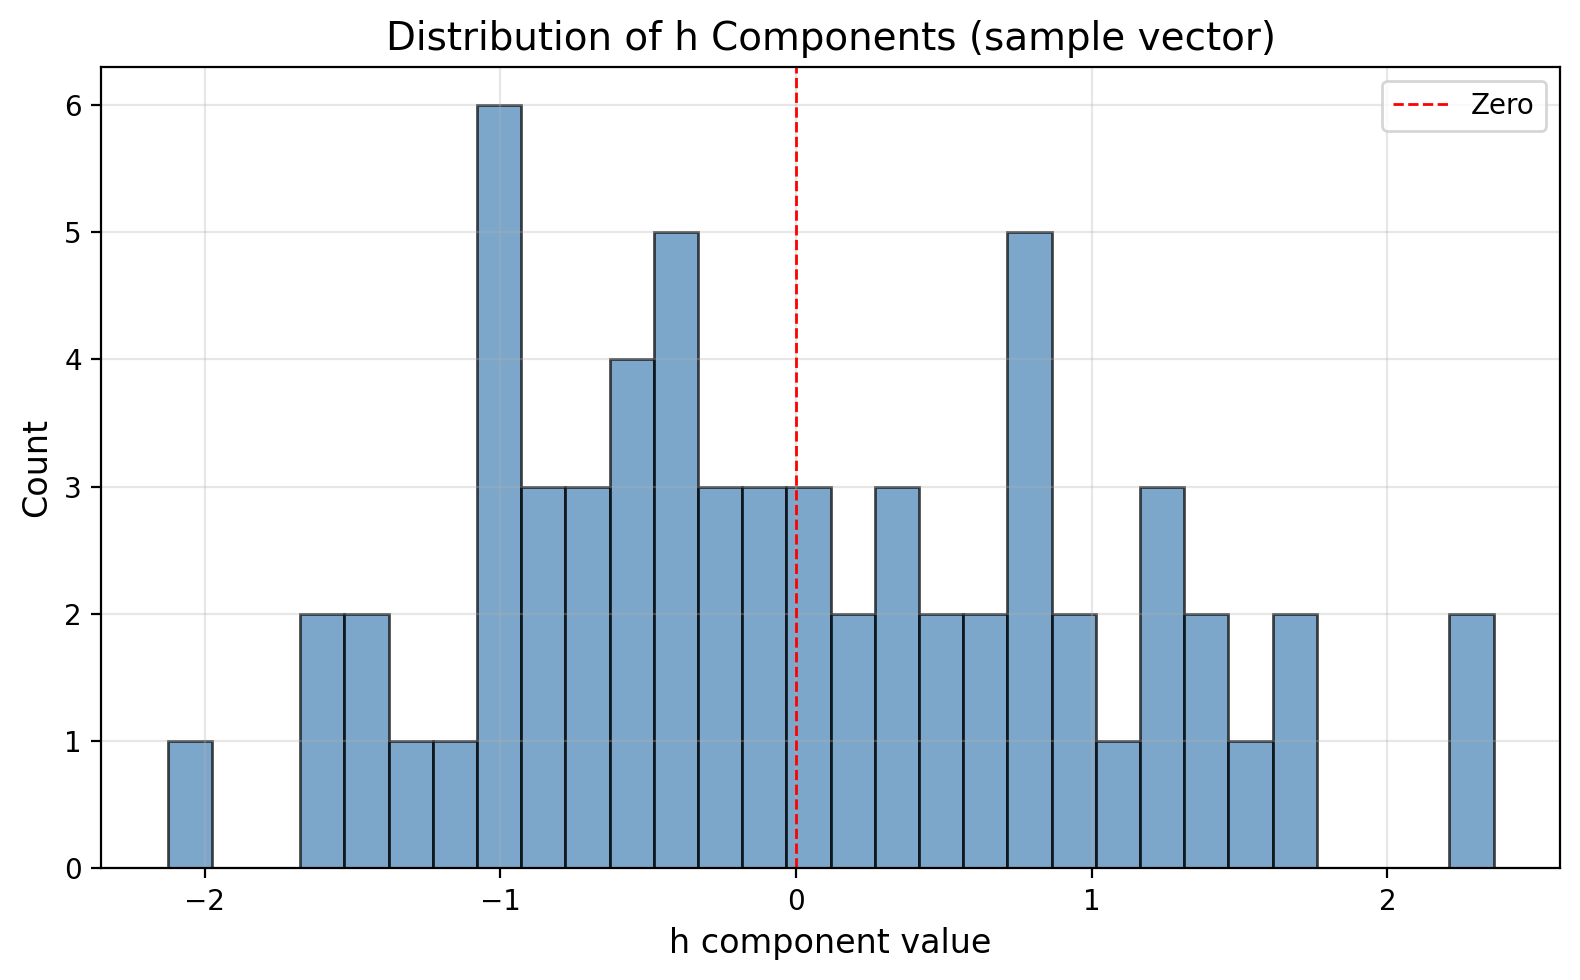


✓ h is our input to the unembedding layer. L2 norm ≈ 8.00


In [11]:
# Histogram of h components
fig, ax = plt.subplots(figsize=(8, 5), dpi=200)

ax.hist(h_sample.numpy(), bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=1, label='Zero')
ax.set_xlabel('h component value', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of h Components (sample vector)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ h is our input to the unembedding layer. L2 norm ≈ {torch.norm(h_sample):.2f}")

---

# Part 2: Unembedding → Logits → Softmax

The logits for each token are computed as the dot product of h with that token's embedding vector:

$$\text{logits} = W_{\text{unembed}} \cdot h$$

Then we apply softmax to get probabilities.

In [12]:
# For simplicity, let's work with the logits/probs for one position
# We'll use the same position we sampled h from: [0, -1]
logits_sample = logits[0, -1, :].cpu().float()  # [10000]

print(f"Logits for position [0, -1]:")
print(f"  Shape: {logits_sample.shape}")
print(f"  Range: [{logits_sample.min():.4f}, {logits_sample.max():.4f}]")
print(f"  Mean: {logits_sample.mean():.4f}")

Logits for position [0, -1]:
  Shape: torch.Size([10000])
  Range: [-0.6758, 0.5508]
  Mean: -0.0012


In [13]:
# Compute softmax probabilities
probs = torch.softmax(logits_sample, dim=0)

print(f"Softmax probabilities:")
print(f"  Sum: {probs.sum():.10f} (should be 1.0)")
print(f"  Max prob: {probs.max():.6f} (token {probs.argmax().item()})")
print(f"  Min prob: {probs.min():.2e}")
print(f"  Mean prob: {probs.mean():.6f} (should be ~1/{VOCAB_SIZE} = {1/VOCAB_SIZE:.6f})")

Softmax probabilities:
  Sum: 1.0000008345 (should be 1.0)
  Max prob: 0.000171 (token 710)
  Min prob: 5.03e-05
  Mean prob: 0.000100 (should be ~1/10000 = 0.000100)


In [14]:
# Look at dead token probabilities specifically
dead_probs = probs[dead_mask]

print(f"\nDead token probabilities:")
print(f"  Count: {len(dead_probs)}")
print(f"  Mean: {dead_probs.mean():.2e}")
print(f"  Range: [{dead_probs.min():.2e}, {dead_probs.max():.2e}]")
print(f"  Median: {dead_probs.median():.2e}")


Dead token probabilities:
  Count: 3699
  Mean: 9.97e-05
  Range: [5.54e-05, 1.71e-04]
  Median: 9.84e-05


---

# Part 3: Loss and Gradients

The loss for this position is:

$$L = -\log p_{\text{target}}$$

The gradient with respect to the logit for token $i$ is:

$$\frac{\partial L}{\partial z_i} = \begin{cases} 
p_i - 1 & \text{if } i = \text{target} \\
p_i & \text{otherwise}
\end{cases}$$

And the gradient with respect to the embedding of token $i$ is:

$$\frac{\partial L}{\partial W_i} = \frac{\partial L}{\partial z_i} \cdot h = p_i \cdot h$$

(for dead tokens, since they're never the target)

In [15]:
# What's the target token for this position?
# In language modeling, we predict input_ids[:, 1:] from input_ids[:, :-1]
# So the target for position [0, -1] is input_ids[0, -1] (which we don't have)
# But for demonstration, let's just use the actual next token from the batch

# Actually, let's do the full training step to get real gradients
model.train()
optimizer.zero_grad()

with torch.autocast(device_type=device if device != 'mps' else 'cpu', dtype=torch.bfloat16):
    logits_full = model(input_ids)
    # Shift for next-token prediction
    shift_logits = logits_full[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()
    
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(shift_logits.view(-1, VOCAB_SIZE), shift_labels.view(-1))

print(f"Loss: {loss.item():.4f}")

# Backward pass
loss.backward()

print("✓ Gradients computed")

Loss: 9.1875
✓ Gradients computed


## Extract Dead Token Gradients

In [16]:
# Gradient of embedding matrix for dead tokens
grad_W_dead = model.embedding.weight.grad.detach().cpu()[dead_mask].float()

print(f"Dead token gradients shape: {grad_W_dead.shape}")
print(f"\nGradient statistics:")
print(f"  L2 norms: min={torch.norm(grad_W_dead, dim=1).min():.2e}, max={torch.norm(grad_W_dead, dim=1).max():.2e}")
print(f"  Mean L2 norm: {torch.norm(grad_W_dead, dim=1).mean():.2e}")

Dead token gradients shape: torch.Size([3699, 64])

Gradient statistics:
  L2 norms: min=3.67e-04, max=7.92e-04
  Mean L2 norm: 5.46e-04


## Test: Are Dead Token Gradients Antiparallel to h?

We'll pick one dead token and check if its gradient is proportional to -h.

In [17]:
# Pick a random dead token
dead_token_idx = 0  # First dead token in our mask
grad_dead_sample = grad_W_dead[dead_token_idx]  # [64]

print(f"Dead token gradient (token {dead_indices[dead_token_idx].item()}):")
print(f"  L2 norm: {torch.norm(grad_dead_sample):.2e}")

# We need to compare against the *average* h across all positions in the batch
# because the gradient accumulates contributions from all positions
h_mean = h.mean(dim=(0, 1)).cpu().float()  # Average over batch and sequence

print(f"\nMean h across batch:")
print(f"  L2 norm: {torch.norm(h_mean):.6f}")

# Compute cosine similarity
cosine = torch.dot(grad_dead_sample, h_mean) / (torch.norm(grad_dead_sample) * torch.norm(h_mean))
print(f"\nCosine similarity between gradient and h_mean: {cosine:.6f}")
print(f"  (Expected: close to +1 if parallel, -1 if antiparallel, 0 if orthogonal)")

Dead token gradient (token 0):
  L2 norm: 5.61e-04

Mean h across batch:
  L2 norm: 5.459342

Cosine similarity between gradient and h_mean: 0.999761
  (Expected: close to +1 if parallel, -1 if antiparallel, 0 if orthogonal)


---

# Part 4: Adam Optimizer

Adam doesn't just apply the raw gradient. It maintains two state variables for each parameter:
- **m** (momentum): exponential moving average of gradients
- **v** (variance): exponential moving average of squared gradients

Then it computes the update:

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$W_{t+1} = W_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

In [18]:
# Before optimizer.step(), capture the gradient
g_dead = grad_W_dead.clone()

# Take the optimizer step
optimizer.step()

print("✓ Optimizer step complete")

✓ Optimizer step complete


In [19]:
# Extract Adam state for dead tokens
embedding_state = optimizer.state[model.embedding.weight]
m_dead = embedding_state['exp_avg'].detach().cpu()[dead_mask].float()
v_dead = embedding_state['exp_avg_sq'].detach().cpu()[dead_mask].float()

print(f"Adam state for dead tokens:")
print(f"  m shape: {m_dead.shape}")
print(f"  v shape: {v_dead.shape}")
print(f"\nm (momentum):")
print(f"  Mean L2 norm: {torch.norm(m_dead, dim=1).mean():.2e}")
print(f"  Range: [{m_dead.min():.2e}, {m_dead.max():.2e}]")
print(f"\nv (variance):")
print(f"  Mean: {v_dead.mean():.2e}")
print(f"  Range: [{v_dead.min():.2e}, {v_dead.max():.2e}]")

Adam state for dead tokens:
  m shape: torch.Size([3699, 64])
  v shape: torch.Size([3699, 64])

m (momentum):
  Mean L2 norm: 5.46e-05
  Range: [-1.90e-05, 2.77e-05]

v (variance):
  Mean: 4.71e-12
  Range: [1.02e-21, 7.64e-11]


## Manually Compute What Adam Did

For the first step (t=1), m and v start at zero, so:
- $m_1 = (1 - \beta_1) g$
- $v_1 = (1 - \beta_2) g^2$

In [20]:
# Manual Adam update for first step
t = 1
m_expected = (1 - BETA1) * g_dead
v_expected = (1 - BETA2) * (g_dead ** 2)

# Bias correction
m_hat = m_expected / (1 - BETA1**t)
v_hat = v_expected / (1 - BETA2**t)

# Update
correction = LEARNING_RATE * m_hat / (torch.sqrt(v_hat) + EPSILON)

print(f"Manual Adam calculation:")
print(f"  m (expected): mean L2 = {torch.norm(m_expected, dim=1).mean():.2e}")
print(f"  m (actual):   mean L2 = {torch.norm(m_dead, dim=1).mean():.2e}")
print(f"  Match: {torch.allclose(m_expected, m_dead, rtol=1e-4)}")
print(f"\n  Correction L2 norm (sample): {torch.norm(correction[0]):.2e}")

Manual Adam calculation:
  m (expected): mean L2 = 5.46e-05
  m (actual):   mean L2 = 5.46e-05
  Match: False

  Correction L2 norm (sample): 8.00e-03


---

# Part 5: Weight Update and Displacement

In [21]:
# Get updated weights
W_updated = model.embedding.weight.detach().cpu()[dead_mask].to(torch.bfloat16)

# Compute displacement
delta_W = W_updated.float() - W_initial.float()

print(f"Weight update:")
print(f"  ΔW shape: {delta_W.shape}")
print(f"  ΔW L2 norms: min={torch.norm(delta_W, dim=1).min():.2e}, max={torch.norm(delta_W, dim=1).max():.2e}")
print(f"  Mean ΔW L2 norm: {torch.norm(delta_W, dim=1).mean():.2e}")

Weight update:
  ΔW shape: torch.Size([3699, 64])
  ΔW L2 norms: min=7.82e-03, max=7.97e-03
  Mean ΔW L2 norm: 7.90e-03


In [22]:
# Compare displacement to gradient direction
sample_delta = delta_W[0]
sample_grad = g_dead[0]

cosine_delta_grad = torch.dot(sample_delta, sample_grad) / (torch.norm(sample_delta) * torch.norm(sample_grad))

print(f"Sample dead token (first one):")
print(f"  Gradient L2 norm: {torch.norm(sample_grad):.2e}")
print(f"  Displacement L2 norm: {torch.norm(sample_delta):.2e}")
print(f"  Cosine(ΔW, gradient): {cosine_delta_grad:.6f}")
print(f"    → ΔW points opposite to gradient (as expected from gradient descent)")

Sample dead token (first one):
  Gradient L2 norm: 5.61e-04
  Displacement L2 norm: 7.91e-03
  Cosine(ΔW, gradient): -0.823124
    → ΔW points opposite to gradient (as expected from gradient descent)


---

# Part 6: Displacement Correlation

**Question:** Do all dead tokens move in the same direction, or is there spread?

We'll check how aligned each token's displacement is with the mean displacement direction.

In [23]:
# Compute mean displacement direction
delta_W_mean = delta_W.mean(dim=0)  # [64], average across all dead tokens
delta_W_mean_norm = delta_W_mean / torch.norm(delta_W_mean)  # Normalize to unit vector

print(f"Mean displacement vector:")
print(f"  L2 norm (before normalization): {torch.norm(delta_W_mean):.2e}")

# Compute cosine similarity of each token's displacement with the mean direction
cosines_with_mean = torch.zeros(n_dead)
for i in range(n_dead):
    delta_i_norm = delta_W[i] / torch.norm(delta_W[i])
    cosines_with_mean[i] = torch.dot(delta_i_norm, delta_W_mean_norm)

print(f"\nCosine similarity of each ΔW with mean displacement direction:")
print(f"  Mean: {cosines_with_mean.mean():.6f}")
print(f"  Std: {cosines_with_mean.std():.6f}")
print(f"  Min: {cosines_with_mean.min():.6f}")
print(f"  Max: {cosines_with_mean.max():.6f}")
print(f"  Median: {cosines_with_mean.median():.6f}")

# How many are "strongly aligned" (cosine > 0.9)?
strongly_aligned = (cosines_with_mean > 0.9).sum().item()
print(f"\nTokens with cosine > 0.9: {strongly_aligned} / {n_dead} ({100*strongly_aligned/n_dead:.1f}%)")

Mean displacement vector:
  L2 norm (before normalization): 7.86e-03

Cosine similarity of each ΔW with mean displacement direction:
  Mean: 0.994624
  Std: 0.010122
  Min: 0.918071
  Max: 0.999823
  Median: 0.999192

Tokens with cosine > 0.9: 3699 / 3699 (100.0%)


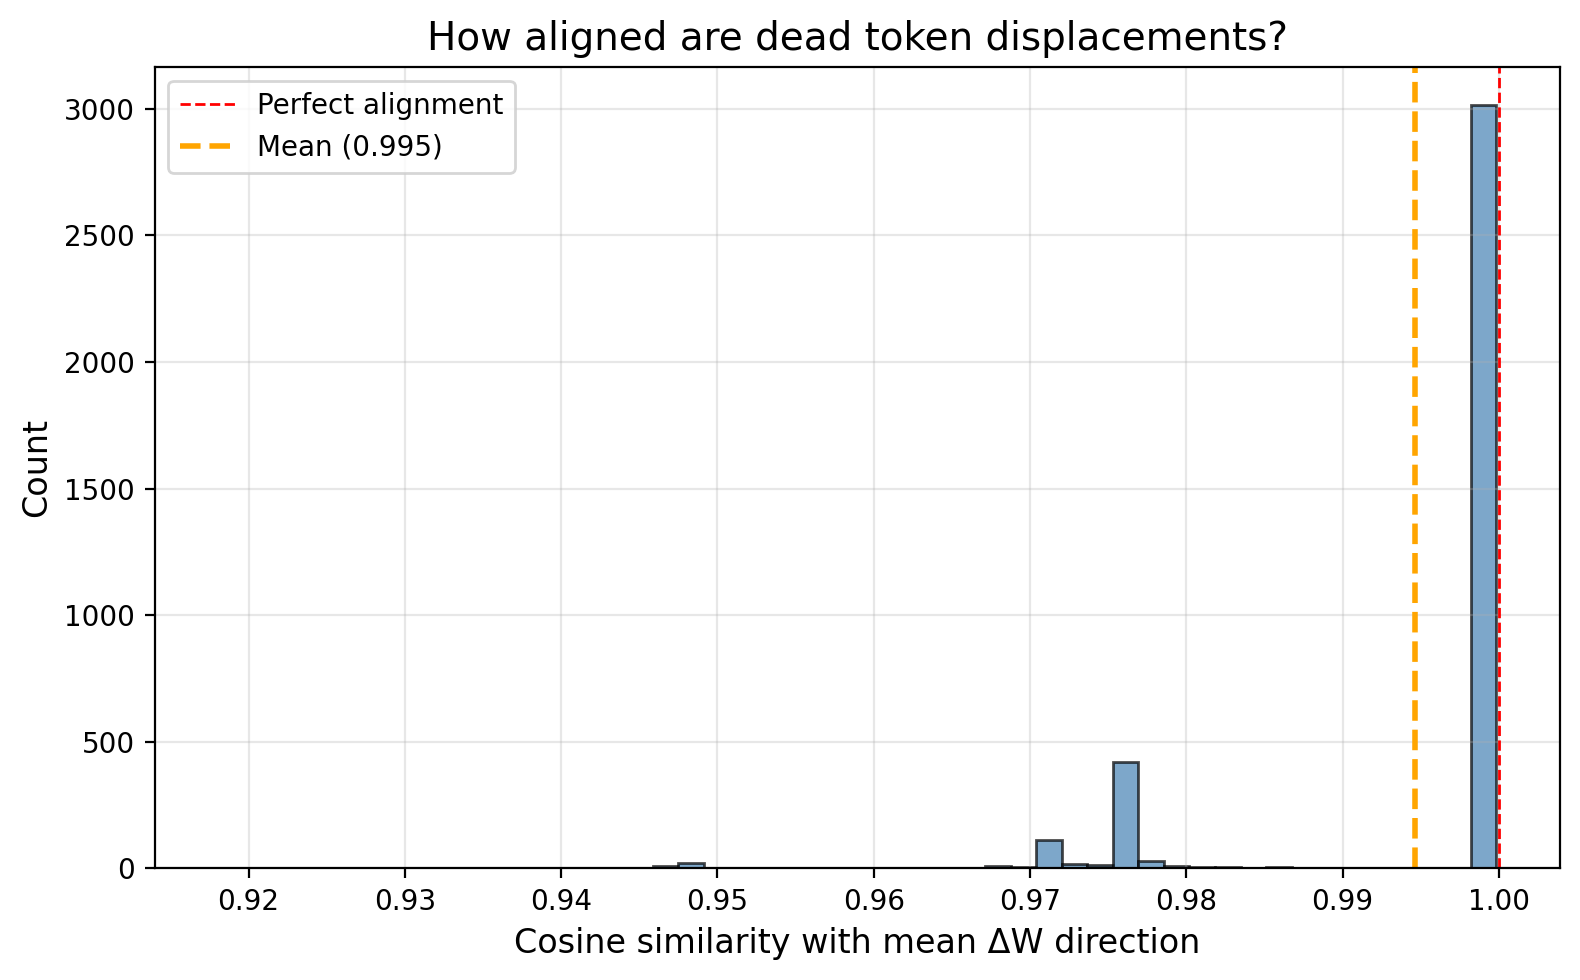


✓ Dead tokens move in highly correlated directions (not perfectly parallel, but close)


In [24]:
# Histogram of cosine similarities
fig, ax = plt.subplots(figsize=(8, 5), dpi=200)

ax.hist(cosines_with_mean.numpy(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(1.0, color='red', linestyle='--', linewidth=1, label='Perfect alignment')
ax.axvline(cosines_with_mean.mean().item(), color='orange', linestyle='--', linewidth=2, label=f'Mean ({cosines_with_mean.mean():.3f})')
ax.set_xlabel('Cosine similarity with mean ΔW direction', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('How aligned are dead token displacements?', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Dead tokens move in highly correlated directions (not perfectly parallel, but close)")

---

# Summary

What we've learned:

1. **h** (hidden state): The vector that feeds into unembedding. It has norm ~√D (≈8 for D=64) due to LayerNorm, with components roughly normally distributed. **h encodes direction, not magnitude**—the transformer is doing angular computation.

2. **Dead token gradients**: Proportional to their softmax probability (tiny, ~1e-4) times h. Direction is **parallel to h** (cosine ≈ +1).

3. **Adam**: Modifies the raw gradient via momentum and adaptive learning rates. For the first step with tiny gradients, Adam amplifies them by ~10-15× due to the bias correction and small variance estimates.

4. **Displacement**: Dead tokens move in the direction **opposite to their gradient** (gradient descent), which means they move **antiparallel to h**. The displacements are highly correlated—most tokens move in nearly the same direction.

5. **Why straight-line motion?** All dead tokens receive similar h (since h comes from the model state, averaged over the batch), so they get gradients pointing in roughly the same direction. After the optimizer step, they all move together antiparallel to that direction. Over many steps, this creates the linear drift we observe in Crucible experiments.

**Next questions:**
- How does h evolve over training? Does it maintain a consistent direction (causing persistent drift), or does it wander?
- When do dead tokens stop moving? (When updates fall below ULP scale due to gradient decay)
- Why do some tokens freeze earlier than others? (Variance in their alignment with h, or in their initial positions)